In [ ]:
!pip install gmft>=0.2.1 -q

In [ ]:
!pip show gmft

Name: gmft
Version: 0.2.1
Summary: Lightweight, performant, configurable, deep table extraction
Home-page: 
Author: conjunct
Author-email: 
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: matplotlib, pandas, pillow, pypdfium2, timm, transformers
Required-by: 


In [ ]:
# get the PubTables-1M paper, source of original Table Transformer (TATR)
!mkdir ./samples
!wget -O ./samples/tatr.pdf -q https://arxiv.org/pdf/2110.00061
!wget -O ./samples/attention.pdf -q https://arxiv.org/pdf/1706.03762
!wget -O ./samples/nmr.pdf -q http://ccc.chem.pitt.edu/wipf/Web/NMR_Impurities.pdf

## tatr.pdf, attention.pdf, and nmr.pdf

In [ ]:
import gmft

from gmft.pdf_bindings import PyPDFium2Document
from gmft import CroppedTable, AutoTableDetector

detector = AutoTableDetector()

from gmft import AutoTableFormatter
from gmft import AutoFormatConfig

config = AutoFormatConfig()
config.semantic_spanning_cells = True # [Experimental] better spanning cells
config.enable_multi_header = True # multi-indices
formatter = AutoTableFormatter(config)

def ingest_pdf(pdf_path) -> list[CroppedTable]:
    doc = PyPDFium2Document(pdf_path)

    tables = []
    for page in doc:
        tables += detector.extract(page)
    return tables, doc


In [ ]:
import time
import json
_total_detect_time = 0
_total_detect_num = 0
_total_format_time = 0
_total_format_num = 0

results = []
images = []
dfs = []
for paper in ['tatr.pdf', 'attention.pdf', 'nmr.pdf']:
  start = time.time()
  tables, doc = ingest_pdf('./samples/' + paper)
  num_pages = len(doc)
  end_detect = time.time()
  formatted_tables = []
  for i, table in enumerate(tables):
    ft = formatter.extract(table)
    # with open(f'{paper[:-4]}_{i}.info', 'w') as f:
        # f.write(json.dumps(ft.to_dict()))
    try:
      dfs.append(ft.df())
    except Exception as e:
      print(e)
      dfs.append(None)
    formatted_tables.append(ft)
    # cache images, because closing document will prevent image access
    images.append(ft.image())
  end_format = time.time()


  doc.close()
  results += formatted_tables
  print(f"Paper: {paper}\nDetect time: {end_detect - start:.3f}s for {num_pages} pages")
  print(f"Format time: {end_format - end_detect:.3f}s for {len(tables)} tables\n")
  _total_detect_time += end_detect - start
  _total_detect_num += num_pages
  _total_format_time += end_format - end_detect
  _total_format_num += len(tables)
print(f"Macro: {_total_detect_time/_total_detect_num:.3f} s/page and {_total_format_time/_total_format_num:.3f} s/table ")

Paper: tatr.pdf
Detect time: 13.887s for 10 pages
Format time: 5.363s for 6 tables

Paper: attention.pdf
Detect time: 21.382s for 15 pages
Format time: 5.551s for 5 tables

The identified boxes have significant overlap: 37.32% of area is overlapping (Max is 20.00%)
Invoking large table row guess! set TATRFormatConfig.force_large_table_assumption to False to disable this.
Invoking large table row guess! set TATRFormatConfig.force_large_table_assumption to False to disable this.
Invoking large table row guess! set TATRFormatConfig.force_large_table_assumption to False to disable this.
Paper: nmr.pdf
Detect time: 12.317s for 9 pages
Format time: 8.716s for 5 tables

Macro: 1.400 s/page and 1.227 s/table 


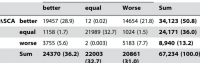

Empty DataFrame
Columns: [, , , , , ]
Index: []

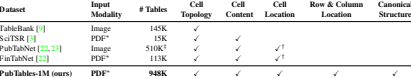

Dataset Input Modality  ... Row & Column Location Canonical Structure
0        TableBank [9]          Image  ...                                          
1           SciTSR [3]           PDF∗  ...                                          
2   PubTabNet [22, 23]          Image  ...                                          
3       FinTabNet [22]           PDF∗  ...                                          
4  PubTables-1M (ours)           PDF∗  ...                     X                   X

[5 rows x 8 columns]

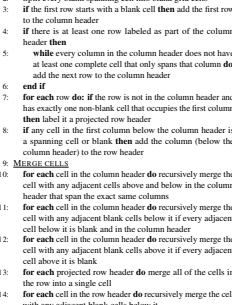

0      2:  Split every blank spanning cell into blank gri...
1      3:  if the first row starts with a blank cell then...
2      4:  if there is at least one row labeled as part o...
3   5: 6:  while every column in the column header does n...
4      7:  for each row do: if the row is not in the colu...
5                   has non-blank cell that the first column
6      8:  exactly one occupies then label it a projected...
7          a spanning cell or blank then add the column (...
8      9:       column header) to the row header MERGE CELLS
9     10:  for each cell in the column header do recursiv...
10    11:  header that span the exact same columns for ea...
11    12:  for each cell in the column header do recursiv...
12    13:  for each projected row header do merge all of ...
13    14:  for each cell in the row header do recursively...

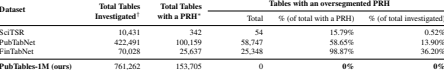

Header 2                  NaN  ... Tables with an oversegmented PRH
Header 1              Dataset  ...        % (of total investigated)
0                      SciTSR  ...                            0.52%
1                   PubTabNet  ...                           13.90%
2                   FinTabNet  ...                           36.20%
3         PubTables-1M (ours)  ...                               0%

[4 rows x 6 columns]

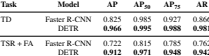

Task         Model     AP   AP50   AP75     AR
0        TD  Faster R-CNN  0.825  0.985  0.927  0.866
1        TD          DETR  0.966  0.995  0.988  0.981
2  TSR + FA  Faster R-CNN  0.722  0.815  0.785  0.762
3  TSR + FA          DETR  0.912  0.971  0.948  0.942

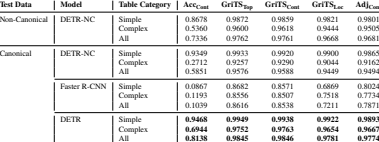

Test Data         Model Table Category AccCont GriTSTop GriTSCont GriTSLoc AdjCont
0   Non-Canonical       DETR-NC         Simple  0.8678   0.9872    0.9859   0.9821  0.9801
1   Non-Canonical       DETR-NC        Complex  0.5360   0.9600    0.9618   0.9444  0.9505
2   Non-Canonical       DETR-NC            All  0.7336   0.9762    0.9761   0.9668  0.9681
3       Canonical       DETR-NC         Simple  0.9349   0.9933    0.9920   0.9900  0.9865
4       Canonical       DETR-NC        Complex  0.2712   0.9257    0.9290   0.9044  0.9162
5       Canonical       DETR-NC            All  0.5851   0.9576    0.9588   0.9449  0.9494
6       Canonical  Faster R-CNN         Simple  0.0867   0.8682    0.8571   0.6869  0.8024
7       Canonical  Faster R-CNN        Complex  0.1193   0.8556    0.8507   0.7518  0.7734
8       Canonical  Faster R-CNN            All  0.1039   0.8616    0.8538   0.7211  0.7871
9       Canonical          DETR         Simple  0.9468   0.9949    0.9938   0.9922  0.9893
10      Canonical          DETR        Complex  0.6944   0.9752    0.9763   0.9654  0.9667
11      Canonical          DETR            All  0.8138   0.9845    0.9846   0.9781  0.9774

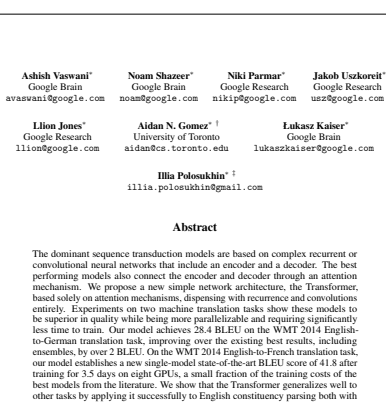

Ashish Vaswani∗ Google Brain avaswani@google.com  ...    Jakob Uszkoreit∗ Google Research usz@google.com
0                                              Llion  ...                                            Kaiser∗
1            Jones∗ Google Research llion@google.com  ...               Google Brain lukaszkaiser@google.com
2                                                     ...                                                   
3  The dominant sequence convolutional neural per...  ...  recurrent or decoder. The best an attention Tr...

[4 rows x 5 columns]

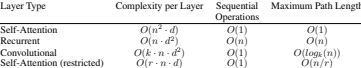

Layer Type Complexity per Layer Sequential Operations Maximum Path Length
0               Self-Attention           O(n 2 · d)                  O(1)                O(1)
1                    Recurrent          O(n · d 2 )                  O(n)                O(n)
2                Convolutional      O(k · n · d 2 )                  O(1)          O(logk(n))
3  Self-Attention (restricted)         O(r · n · d)                  O(1)              O(n/r)

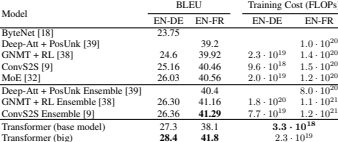

Header 2                              NaN   BLEU  ... Training Cost (FLOPs) is_projecting_row
Header 1                            Model  EN-DE  ...                 EN-FR                  
0                            ByteNet [18]  23.75  ...                                    True
1                  Deep-Att + PosUnk [39]         ...            1.0 · 1020              True
2                          GNMT + RL [38]   24.6  ...            1.4 · 1020             False
3                             ConvS2S [9]  25.16  ...            1.5 · 1020             False
4                                MoE [32]  26.03  ...            1.2 · 1020             False
5         Deep-Att + PosUnk Ensemble [39]         ...            8.0 · 1020             False
6                 GNMT + RL Ensemble [38]  26.30  ...            1.1 · 1021             False
7                    ConvS2S Ensemble [9]  26.36  ...            1.2 · 1021             False
8                Transformer (base model)   27.3  ...                  1018             False
9                       Transformer (big)   28.4  ...                  1019             False

[10 rows x 6 columns]

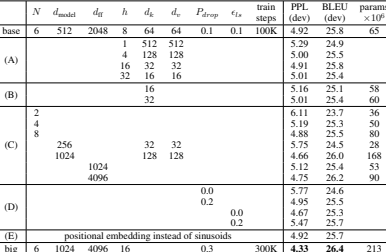

N dmodel         dff          h  ...  ϵls train steps PPL (dev) BLEU (dev) params ×106
0   base  6    512        2048          8  ...  0.1        100K      4.92       25.8          65
1   base                                1  ...                       5.29       24.9            
2   base                                4  ...                       5.00       25.5            
3    (A)                               16  ...                       4.91       25.8            
4    (A)                               32  ...                       5.01       25.4            
5    (A)                                   ...                       5.16       25.1          58
6    (B)                                   ...                       5.01       25.4          60
7    (B)  2                                ...                       6.11       23.7          36
8    (B)  4                                ...                       5.19       25.3          50
9    (B)  8                                ...                       4.88       25.5          80
10   (C)       256                         ...                       5.75       24.5          28
11   (C)      1024                         ...                       4.66       26.0         168
12   (C)                  1024             ...                       5.12       25.4          53
13   (C)                  4096             ...                       4.75       26.2          90
14   (C)                                   ...                       5.77       24.6            
15   (C)                                   ...                       4.95       25.5            
16   (D)                                   ...  0.0                  4.67       25.3            
17   (D)                                   ...  0.2                  5.47       25.7            
18   (E)            positional  embedding  ...                       4.92       25.7            
19   big  6   1024        4096         16  ...             300K      4.33       26.4         213

[20 rows x 13 columns]

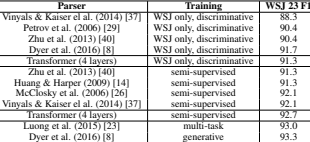

Parser                  Training WSJ 23 F1
0   Vinyals & Kaiser el al. (2014) [37]  WSJ only, discriminative      88.3
1             Petrov et al. (2006) [29]  WSJ only, discriminative      90.4
2                Zhu et al. (2013) [40]  WSJ only, discriminative      90.4
3                Dyer et al. (2016) [8]  WSJ only, discriminative      91.7
4                Transformer (4 layers)  WSJ only, discriminative      91.3
5                Zhu et al. (2013) [40]           semi-supervised      91.3
6            Huang & Harper (2009) [14]           semi-supervised      91.3
7           McClosky et al. (2006) [26]           semi-supervised      92.1
8   Vinyals & Kaiser el al. (2014) [37]           semi-supervised      92.1
9                Transformer (4 layers)           semi-supervised      92.7
10             Luong et al. (2015) [23]                multi-task      93.0
11               Dyer et al. (2016) [8]                generative      93.3

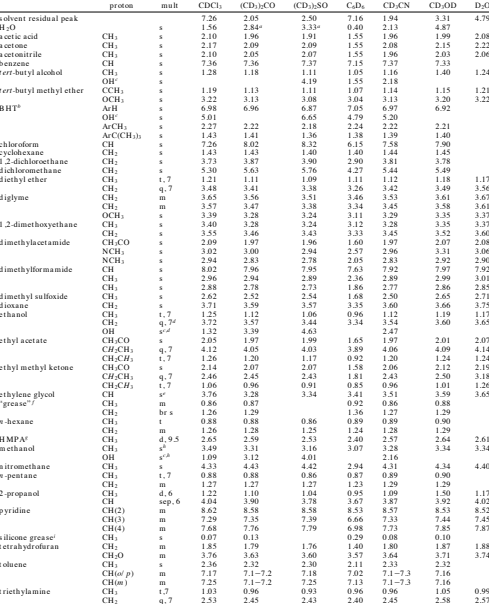

pr ot on   m ult CDCl3  ...    CD3CN CD3OD   D2O is_projecting_row
0        solvent r esidu al pea k                     7.26  ...     1.94  3.31  4.79             False
1                             H2O                  s  1.56  ...     2.13  4.87                   False
2                   a cetic a cid        CH3       s  2.10  ...     1.96  1.99  2.08             False
3                      a cet on e        CH3       s  2.17  ...     2.08  2.15  2.22             False
4                 a cet onit rile        CH3       s  2.10  ...     1.96  2.03  2.06             False
5                         benzene         CH       s  7.36  ...     7.37  7.33                   False
6            tert-but yl alcoh ol        CH3       s  1.28  ...     1.16  1.40  1.24             False
7            tert-but yl alcoh ol        OHc       s        ...     2.18                         False
8   tert-but yl m et h yl et h er       CCH3       s  1.19  ...     1.14  1.15  1.21             False
9   tert-but yl m et h yl et h er       OCH3       s  3.22  ...     3.13  3.20  3.22             False
10                           BHTb        ArH       s  6.98  ...     6.97  6.92                   False
11                           BHTb        OHc       s  5.01  ...     5.20                         False
12                           BHTb      ArCH3       s  2.27  ...     2.22  2.21                   False
13                           BHTb  ArC(CH3)3       s  1.43  ...     1.39  1.40                   False
14                    chlor oform         CH       s  7.26  ...     7.58  7.90                   False
15                 cycloh exa n e        CH2       s  1.43  ...     1.44  1.45                   False
16        1,2-dichlor oet h a n e        CH2       s  3.73  ...     3.81  3.78                   False
17          dichlor om et h a n e        CH2       s  5.30  ...     5.44  5.49                   False
18                  diethyl ether        CH3    t, 7  1.21  ...     1.12  1.18  1.17             False
19                  diethyl ether        CH2    q, 7  3.48  ...     3.42  3.49  3.56             False
20                        diglyme        CH2       m  3.65  ...     3.53  3.61  3.67             False
21                        diglyme        CH2       m  3.57  ...     3.45  3.58  3.61             False
22                        diglyme       OCH3       s  3.39  ...     3.29  3.35  3.37             False
23     1,2-dim et h oxyet h a n e        CH3       s  3.40  ...     3.28  3.35  3.37             False
24     1,2-dim et h oxyet h a n e        CH2       s  3.55  ...     3.45  3.52  3.60             False
25         dim et h yla cet amide      CH3CO       s  2.09  ...     1.97  2.07  2.08             False
26         dim et h yla cet amide       NCH3       s  3.02  ...     2.96  3.31  3.06             False
27         dim et h yla cet amide       NCH3       s  2.94  ...     2.83  2.92  2.90             False
28          dim et h ylform amide         CH       s  8.02  ...     7.92  7.97  7.92             False
29          dim et h ylform amide        CH3       s  2.96  ...     2.89  2.99  3.01             False
30          dim et h ylform amide        CH3       s  2.88  ...     2.77  2.86  2.85              True
31          dim et h yl sulfoxide        CH3       s  2.62  ...     2.50  2.65  2.71             False
32                      dioxa n e        CH2       s  3.71  ...     3.60  3.66  3.75             False
33                    et h a n ol        CH3    t, 7  1.25  ...     1.12  1.19  1.17             False
34                    et h a n ol        CH2   q, 7d  3.72  ...     3.54  3.60  3.65             False
35                    et h a n ol         OH    sc,d  1.32  ...     2.47                         False
36             et h yl a cet at e      CH3CO       s  2.05  ...     1.97  2.01  2.07             False
37             et h yl a cet at e     CH2CH3    q, 7  4.12  ...     4.06  4.09  4.14             False
38             et h

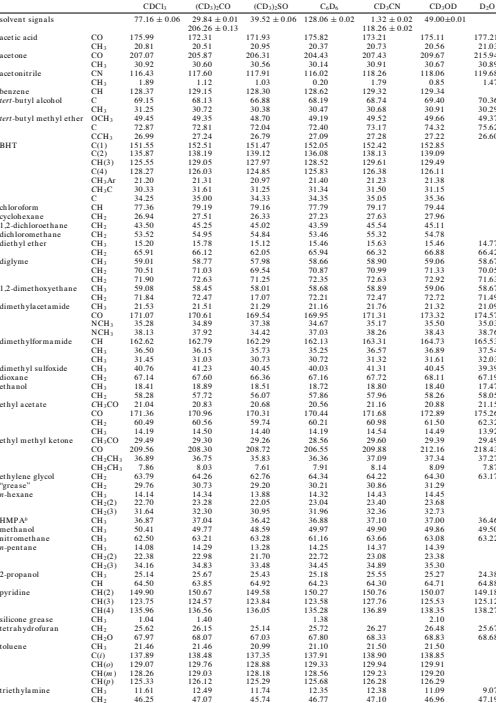

CDCl3  ...          CD3CN       CD3OD     D2O
0                solvent sign als          77.16 ( 0.06  ...    1.32 ( 0.02  49.00(0.01        
1                                                        ...  118.26 ( 0.02                    
2                   a cetic a cid      CO        175.99  ...         173.21      175.11  177.21
3                                     CH3         20.81  ...          20.73       20.56   21.03
4                      a cet on e      CO        207.07  ...         207.43      209.67  215.94
5                                     CH3         30.92  ...          30.91       30.67   30.89
6                 a cet onit rile      CN        116.43  ...         118.26      118.06  119.68
7                                     CH3          1.89  ...           1.79        0.85    1.47
8                         benzene      CH        128.37  ...         129.32      129.34        
9            tert-but yl alcoh ol       C         69.15  ...          68.74       69.40   70.36
10                                    CH3         31.25  ...          30.68       30.91   30.29
11  tert-but yl m et h yl et h er    OCH3         49.45  ...          49.52       49.66   49.37
12                                      C         72.87  ...          73.17       74.32   75.62
13                                   CCH3         26.99  ...          27.28       27.22   26.60
14                            BHT    C(1)        151.55  ...         152.42      152.85        
15                                   C(2)        135.87  ...         138.13      139.09        
16                                 CH (3)        125.55  ...         129.61      129.49        
17                                   C(4)        128.27  ...         126.38      126.11        
18                                  CH3Ar         21.20  ...          21.23       21.38        
19                                   CH3C         30.33  ...          31.50       31.15        
20                                      C         34.25  ...          35.05       35.36        
21                    chlor oform      CH         77.36  ...          79.17       79.44        
22                 cycloh exa n e     CH2         26.94  ...          27.63       27.96        
23        1,2-dichlor oet h a n e     CH2         43.50  ...          45.54       45.11        
24          dichlor om et h a n e     CH2         53.52  ...          55.32       54.78        
25                  diethyl ether     CH3         15.20  ...          15.63       15.46   14.77
26                                    CH2         65.91  ...          66.32       66.88   66.42
27                        diglyme     CH3         59.01  ...          58.90       59.06   58.67
28                                    CH2         70.51  ...          70.99       71.33   70.05
29                                    CH2         71.90  ...          72.63       72.92   71.63
30     1,2-dim et h oxyet h a n e     CH3         59.08  ...          58.89       59.06   58.67
31                                    CH2         71.84  ...          72.47       72.72   71.49
32         dim et h yla cet amide     CH3         21.53  ...          21.76       21.32   21.09
33                                     CO        171.07  ...         171.31      173.32  174.57
34                                   NCH3         35.28  ...          35.17       35.50   35.03
35                                   NCH3         38.13  ...          38.26       38.43   38.76
36          dim et h ylform amide      CH        162.62  ...         163.31      164.73  165.53
37                                    CH3         36.50  ...          36.57       36.89   37.54
38                                    CH3         31.45  ...          31.32       31.61   32.03
39          dim et h yl sulfoxide     CH3         40.76  ...          41.31       40.45   39.39
40                      dioxa n e     CH2         67.14  ...          67.72       68.11   67.19
41                

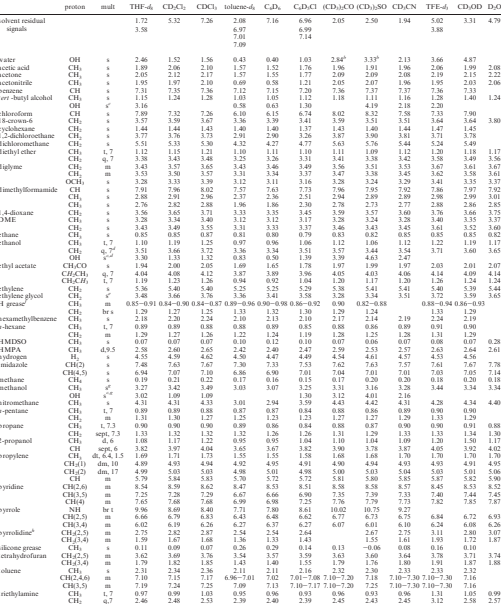

... is_projecting_row
0                            solvent residual signals  ...             False
1   water acetic acid acetone acetonitrile benzene...  ...             False
2   chloroform 18-crown-6 cyclohexane 1,2-dichloro...  ...             False
3                                             diglyme  ...             False
4                                   dimethylformamide  ...             False
5                                     1,4-dioxane DME  ...             False
6                                      ethane ethanol  ...             False
7                                       ethyl acetate  ...             False
8                  ethylene ethylene glycol H greasef  ...             False
9                          hexamethylbenzene n-hexane  ...             False
10                                         HMDSO HMPA  ...             False
11                hydrogen imidazole methane methanol  ...             False
12                             nitromethane n-pentane  ...             False
13                                            propane  ...              True
14                                         2-propanol  ...             False
15                                          propylene  ...             False
16                                           pyridine  ...             False
17                                            pyrrole  ...             False
18                                       pyrrolidineh  ...             False
19                    silicone grease tetrahydrofuran  ...             False
20                                            toluene  ...             False
21                                      triethylamine  ...             False

[22 rows x 21 columns]

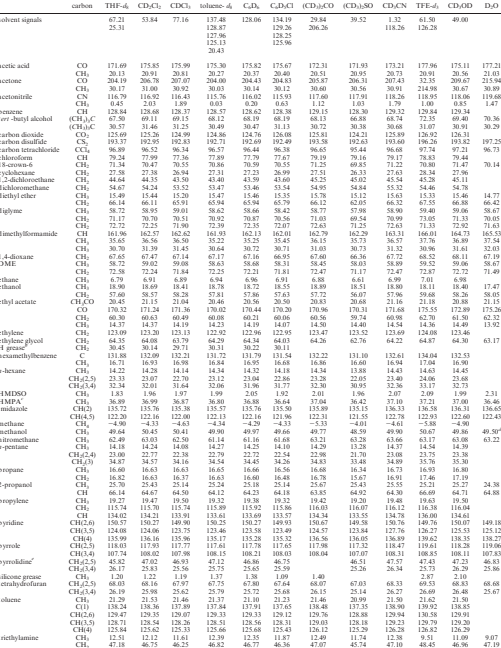

carbon  THF-d8  CD2Cl2  ...  TFE-d3   CD3OD     D2O is_projecting_row
0        solvent signals             67.21   53.84  ...   61.50   49.00                     False
1                                    25.31          ...  126.28                             False
2                                                   ...                                     False
3                                                   ...                                     False
4                                                   ...                                      True
5            acetic acid        CO  171.69  175.85  ...  177.96  175.11  177.21              True
6                              CH3   20.13   20.91  ...   20.91   20.56   21.03             False
7                acetone        CO  204.19  206.78  ...   32.35  209.67  215.94             False
8                              CH3   30.17   31.00  ...  214.98   30.67   30.89             False
9           acetonitrile        CN  116.79  116.92  ...  118.95  118.06  119.68             False
10                             CH3    0.45    2.03  ...    1.00    0.85    1.47             False
11               benzene        CH  128.84  128.68  ...  129.84  129.34                     False
12   tert -butyl alcohol   (CH3)3C   67.50   69.11  ...   72.35   69.40   70.36             False
13                         (CH3)3C   30.57   31.46  ...   31.07   30.91   30.29             False
14        carbon dioxide       CO2  125.69  125.26  ...  126.92  126.31                     False
15      carbon disulfide       CS2  193.37  192.95  ...  196.26  193.82  197.25             False
16  carbon tetrachloride      CCl4   96.89   96.52  ...   97.74   97.21   96.73             False
17            chloroform        CH   79.24   77.99  ...   78.83   79.44                     False
18            18-crown-6       CH2   71.34   70.47  ...   70.80   71.47   70.14             False
19           cyclohexane       CH2   27.58   27.38  ...   28.34   27.96                     False
20    1,2-dichloroethane       CH2   44.64   44.35  ...   45.28   45.11                     False
21       dichloromethane       CH2   54.67   54.24  ...   54.46   54.78                     False
22         diethyl ether       CH3   15.49   15.44  ...   15.33   15.46   14.77             False
23                             CH2   66.14   66.11  ...   67.55   66.88   66.42             False
24               diglyme       CH3   58.72   58.95  ...   59.40   59.06   58.67             False
25                             CH2   71.17   70.70  ...   73.05   71.33   70.05             False
26                             CH2   72.72   72.25  ...   71.33   72.92   71.63             False
27     dimethylformamide        CH  161.96  162.57  ...  166.01  164.73  165.53             False
28                             CH3   35.65   36.56  ...   37.76   36.89   37.54             False
29                             CH3   30.70   31.39  ...   30.96   31.61   32.03             False
30           1,4-dioxane       CH2   67.65   67.47  ...   68.52   68.11   67.19             False
31                   DME       CH3   58.72   59.02  ...   59.52   59.06   58.67             False
32                             CH2   72.58   72.24  ...   72.87   72.72   71.49             False
33                ethane       CH3    6.79    6.91  ...    7.01    6.98                     False
34               ethanol       CH3   18.90   18.69  ...   18.11   18.40   17.47             False
35                             CH2   57.60   58.57  ...   59.68   58.26   58.05             False
36         ethyl acetate     CH3CO   20.45   21.15  ...   21.18   20.88   21.15             False
37                              CO  170.32  171.24  ...  175.55  172.89  175.26             False
38                             CH2   60.30   60.63  ...   62.70   61.50   62.32             False
39                             CH3   14.37   14.37  ...   14.36   14.49   13.92             False
40        

In [ ]:
from IPython.display import display
import pandas as pd

for df, img in zip(dfs, images):
  display(img)
  with pd.option_context('display.max_rows', 500, "display.multi_sparse", False):
    if df is not None:
      display(df.fillna(""))

## bulk extract subset

We will be downloading a bunch of articles to demonstrate bulk extraction. They are all open access articles with permissive licenses. We will be using them unmodified. Many thanks to the respective authors; please see sources in the below table.



| doi                                  | Title                                                                                                                                                     | Author        | Notes                                           | Url                                                                       | License                                                     |
|--------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------|---------------|-------------------------------------------------|---------------------------------------------------------------------------|-------------------------------------------------------------|
| 10.1007/s13201-023-02046-6           | Synthesis of a nanocomposite with holocellulose extracted from barley straw and montmorillonite, and optimization of the removal of methylene blue dye using the synthesized adsorbent | Farzi et al.  |                                                 | [Link](https://link.springer.com/content/pdf/10.1007/s13201-023-02046-6.pdf)  | CC BY 4.0   |
| 10.1007/s40268-021-00343-6           | Population Pharmacokinetic Model of N-acetylmannosamine (ManNAc) and N-acetylneuraminic acid (Neu5Ac) in Subjects with GNE Myopathy                          | Wart et al.   |                                                 | [Link](https://link.springer.com/content/pdf/10.1007/s40268-021-00343-6.pdf)  | CC BY 4.0   |
| 10.1038/s41467-023-38544-z           | Approaching enzymatic catalysis with zeolites or how to select one reaction mechanism competing with others                                                | Ferri et al.  | alternating table style                        | [Link](https://www.nature.com/articles/s41467-023-38544-z.pdf)               | CC BY 4.0   |
| 10.1038/srep17787                    | Deciphering Genomic Underpinnings of Quantitative MRI-based Radiomic Phenotypes of Invasive Breast Carcinoma                                               | Zhu et al.    | image table and difficult table with uneven columns | [Link](https://www.nature.com/articles/srep17787.pdf)                        | CC BY 4.0   |
| 10.1107/s2052252519008285            | Catalytically important damage-free structures of a copper nitrite reductase obtained by femtosecond X-ray laser and room-temperature neutron crystallography | Halsted et al. |                                                 | [Link](https://journals.iucr.org/m/issues/2019/04/00/ec5013/ec5013.pdf)      | CC BY 4.0                                                   |
| 10.1186/s12284-023-00656-x           | The Inferior Grain Filling Initiation Promotes the Source Strength of Rice Leaves                                                                          | Jiang et al.  |                                                 | [Link](https://thericejournal.springeropen.com/counter/pdf/10.1186/s12284-023-00656-x.pdf) | CC BY 4.0   |
| 10.1186/1471-2334-11-124             | Core mutations, IL28B polymorphisms and response to peginterferon/ribavirin treatment in Swedish patients with hepatitis C virus genotype 1 infection      | Alestig et al.| very large table                                | [Link](https://bmcinfectdis.biomedcentral.com/counter/pdf/10.1186/1471-2334-11-124.pdf)    | CC BY 2.0                                                   |
| 10.48550/arXiv.2211.13344            | Solubility of water in peridotite liquids and the prevalence of steam atmospheres on rocky planets                                                         | Sossi et al.  | vertical table                                  | [Link](https://arxiv.org/pdf/2211.13344)                                        | CC BY 4.0   |


In [ ]:
!mkdir ./bulk
!wget -O bulk/1.pdf bulk -q https://link.springer.com/content/pdf/10.1007/s13201-023-02046-6.pdf
!wget -O bulk/2.pdf bulk -q https://link.springer.com/content/pdf/10.1007/s40268-021-00343-6.pdf
!wget -O bulk/3.pdf bulk -q https://www.nature.com/articles/s41467-023-38544-z.pdf
!wget -O bulk/4.pdf bulk -q https://www.nature.com/articles/srep17787.pdf
!wget -O bulk/5.pdf bulk -q https://journals.iucr.org/m/issues/2019/04/00/ec5013/ec5013.pdf
!wget -O bulk/6.pdf bulk -q https://thericejournal.springeropen.com/counter/pdf/10.1186/s12284-023-00656-x.pdf
!wget -O bulk/7.pdf bulk -q https://bmcinfectdis.biomedcentral.com/counter/pdf/10.1186/1471-2334-11-124.pdf
!wget -O bulk/8.pdf bulk -q https://arxiv.org/pdf/2211.13344

In [ ]:
!mkdir results
!mkdir results/false_positives

In [ ]:
import json
import re
page_keywords_re_s = [re.compile(x, re.IGNORECASE) for x in \
                    [r'\btables?\b']]

In [ ]:
import gmft

from gmft.pdf_bindings import PyPDFium2Document
from gmft import CroppedTable, TableDetector

detector = TableDetector()

from gmft import AutoTableFormatter
from gmft import AutoFormatConfig

config = AutoFormatConfig()
config.semantic_spanning_cells = True # [Experimental] better spanning cells
config.verbosity = 0 # Disable messages
formatter = AutoTableFormatter(config)

def ingest_pdf(pdf_path) -> list[CroppedTable]:
    doc = PyPDFium2Document(pdf_path)

    tables = []
    for page in doc:
        page_text = ""
        for text in page.get_positions_and_text():
            page_text += text[4] + " "
        if any([re.search(x, page_text) for x in page_keywords_re_s]):
            tables += detector.extract(page)
    return tables, doc


In [ ]:
import os
from tqdm import tqdm
import traceback

root = "bulk"
save_dir = "results"

last_processed = None # list(os.listdir(root))[4020]

In [ ]:
for filename in tqdm(sorted(os.listdir(root))):
    if last_processed is not None and filename < last_processed:
        continue
    if filename.endswith(".pdf"):
        filename = filename[:-4]
        # check if folder exists
        if os.path.exists(f"{save_dir}/{filename}"):
            continue

        # ingest pdf
        doc = None
        try:
            tables, doc = ingest_pdf(f"{root}/{filename}.pdf")
            exists = False
            for i, table in enumerate(tables):
                # check for keywords presence again
                # text = table.text()
                # if not any([re.search(x, text) for x in table_keywords_re_s]):
                    # continue

                if table.label == 1:
                    if not exists:
                        # make folder
                        os.makedirs(f"{save_dir}/{filename}")
                        exists = True
                    table.image(dpi=144).save(f"{save_dir}/{filename}/{i}_rotated.png")
                    json.dump(table.to_dict(), open(f"{save_dir}/{filename}/{i}_rotated.info.json", "w"))
                    continue
                if not exists:
                    # make folder
                    os.makedirs(f"{save_dir}/{filename}")
                    exists = True
                try:
                    ft = formatter.extract(table)
                    # write image, csv, and info to {save_dir}/{filename}/{table_no}.{png,csv,info.json}
                    ft.image(dpi=144).save(f"{save_dir}/{filename}/{i}.png")
                    # with open(f'{paper[:-4]}_{i}.info', 'w') as f:
                    #     f.write(json.dumps(ft.to_dict()))
                    ft.df().to_csv(f"{save_dir}/{filename}/{i}.csv", index=False)
                    # this includes, for instance, outlier info
                    json.dump(ft.to_dict(), open(f"{save_dir}/{filename}/{i}.info.json", "w"))
                except Exception as e:
                    print(f"Error processing {filename}, {i}, {traceback.format_exc()}")
        except Exception as e:
            print(f"Error processing {filename}, {e}")
            continue
        finally:
            if doc is not None:
                doc.close()


        last_processed = filename

 50%|█████     | 4/8 [01:11<01:05, 16.45s/it]

Invoking large table row guess! set TATRFormatConfig.force_large_table_assumption to False to disable this.


 75%|███████▌  | 6/8 [01:41<00:31, 15.63s/it]

Invoking large table row guess! set TATRFormatConfig.force_large_table_assumption to False to disable this.


100%|██████████| 8/8 [02:07<00:00, 15.92s/it]


(Note that filtering by keywords may speed up inference.)

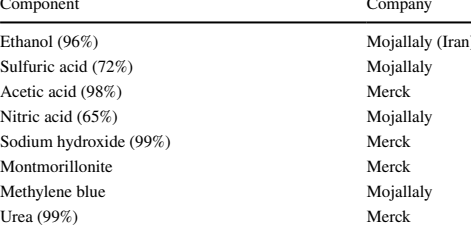

Component           Company
0           Ethanol (96%)  Mojallaly (Iran)
1     Sulfuric acid (72%)         Mojallaly
2       Acetic acid (98%)             Merck
3       Nitric acid (65%)         Mojallaly
4  Sodium hydroxide (99%)             Merck
5         Montmorillonite             Merck
6          Methylene blue         Mojallaly
7              Urea (99%)             Merck

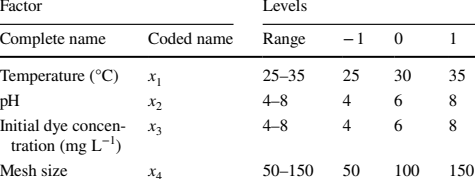

Factor \nComplete name Factor \nCoded name Levels \nRange  \
0                     Temperature (°C)                  x1          25–35   
1                                   pH                  x2            4–8   
2  Initial dye concen￾tration (mg L−1)                  x3            4–8   
3                            Mesh size                  x4         50–150   

   Levels \n−1  Levels \n0  Levels \n1  
0           25          30          35  
1            4           6           8  
2            4           6           8  
3           50         100         150

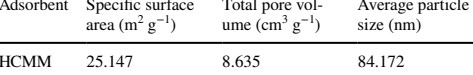

Adsorbent  Specifc surface area (m2 g−1)  Total pore vol￾ume (cm3 g−1)  \
0      HCMM                         25.147                         8.635   

   Average particle size (nm)  
0                      84.172

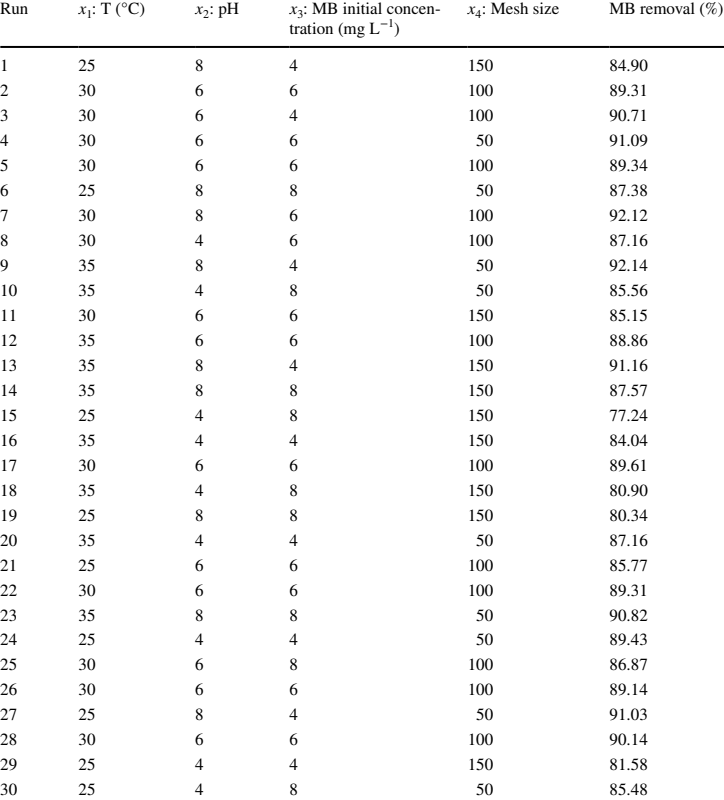

Run  x1: T (°C)  x2: pH  x3: MB initial concen￾tration (mg L−1)  \
0     1          25       8                                       4   
1     2          30       6                                       6   
2     3          30       6                                       4   
3     4          30       6                                       6   
4     5          30       6                                       6   
5     6          25       8                                       8   
6     7          30       8                                       6   
7     8          30       4                                       6   
8     9          35       8                                       4   
9    10          35       4                                       8   
10   11          30       6                                       6   
11   12          35       6                                       6   
12   13          35       8                                       4   
13   14          35       8                                       8   
14   15          25       4                                       8   
15   16          35       4                                       4   
16   17          30       6                                       6   
17   18          35       4                                       8   
18   19          25       8                                       8   
19   20          35       4                                       4   
20   21          25       6                                       6   
21   22          30       6                                       6   
22   23          35       8                                       8   
23   24          25       4                                       4   
24   25          30       6                                       8   
25   26          30       6                                       6   
26   27          25       8                                       4   
27   28          30       6                                       6   
28   29          25       4                                       4   
29   30          25       4                                       8   

    x4: Mesh size  MB removal (%)  
0             150           84.90  
1             100           89.31  
2             100           90.71  
3              50           91.09  
4             100           89.34  
5              50           87.38  
6             100           92.12  
7             100           87.16  
8              50           92.14  
9              50           85.56  
10            150           85.15  
11            100           88.86  
12            150           91.16  
13            150           87.57  
14            150           77.24  
15            150           84.04  
16            100           89.61  
17            150           80.90  
18            150           80.34  
19             50           87.16  
20            100           85.77  
21            100           89.31  
22             50           90.82  
23             50           89.43  
24            100           86.87  
25            100           89.14  
26             50           91.03  
27            100           90.14  
28            150           81.58  
29             50           85.48

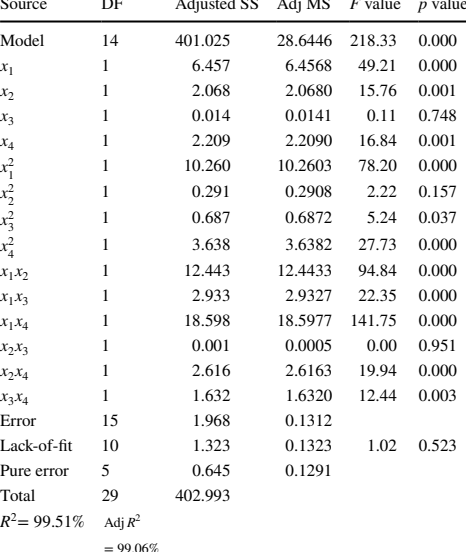

Source        DF Adjusted SS   Adj MS F value p value
0        Model        14     401.025  28.6446  218.33     0.0
1           x1         1       6.457   6.4568   49.21     0.0
2           x2         1       2.068    2.068   15.76   0.001
3           x3         1       0.014   0.0141    0.11   0.748
4           x4         1       2.209    2.209   16.84   0.001
5         x2 1         1       10.26  10.2603    78.2     0.0
6         x2 2         1       0.291   0.2908    2.22   0.157
7         x2 3         1       0.687   0.6872    5.24   0.037
8         x2 4         1       3.638   3.6382   27.73     0.0
9         x1x2         1      12.443  12.4433   94.84     0.0
10        x1x3         1       2.933   2.9327   22.35     0.0
11        x1x4         1      18.598  18.5977  141.75     0.0
12        x2x3         1       0.001   0.0005     0.0   0.951
13        x2x4         1       2.616   2.6163   19.94     0.0
14        x3x4         1       1.632    1.632   12.44   0.003
15       Error        15       1.968   0.1312                
16  Lack-of-ft        10       1.323   0.1323    1.02   0.523
17  Pure error         5       0.645   0.1291                
18       Total        29     402.993                         
19  R2= 99.51%    Adj R2                                     
20              = 99.06%

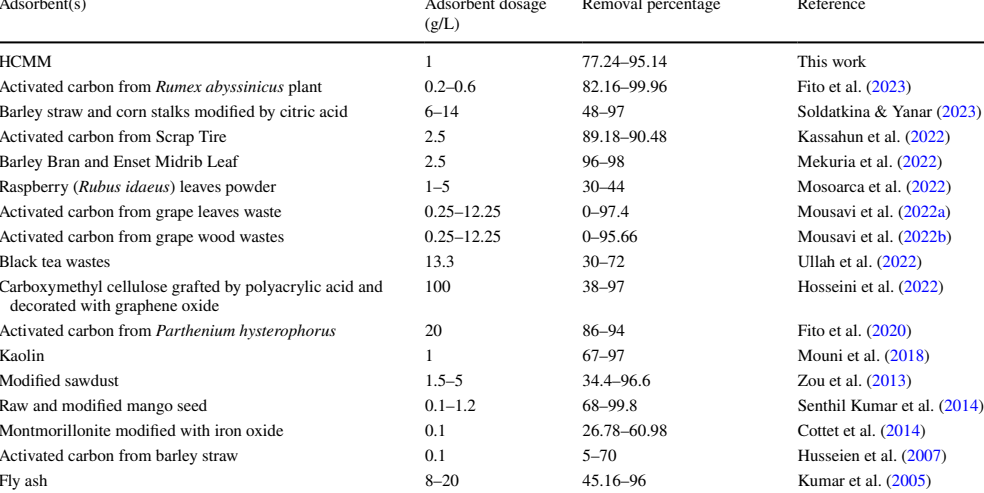

Adsorbent(s) Adsorbent dosage (g/L)  \
0                                                HCMM                      1   
1       Activated carbon from Rumex abyssinicus plant                0.2–0.6   
2   Barley straw and corn stalks modifed by citric...                   6–14   
3                    Activated carbon from Scrap Tire                    2.5   
4                   Barley Bran and Enset Midrib Leaf                    2.5   
5              Raspberry (Rubus idaeus) leaves powder                    1–5   
6            Activated carbon from grape leaves waste             0.25–12.25   
7             Activated carbon from grape wood wastes             0.25–12.25   
8                                    Black tea wastes                   13.3   
9   Carboxymethyl cellulose grafted by polyacrylic...                    100   
10     Activated carbon from Parthenium hysterophorus                     20   
11                                             Kaolin                      1   
12                                    Modifed sawdust                  1.5–5   
13                         Raw and modifed mango seed                0.1–1.2   
14            Montmorillonite modifed with iron oxide                    0.1   
15                 Activated carbon from barley straw                    0.1   
16                                            Fly ash                   8–20   

   Removal percentage                    Reference  
0         77.24–95.14                    This work  
1         82.16–99.96           Fito et al. (2023)  
2               48–97    Soldatkina & Yanar (2023)  
3         89.18–90.48       Kassahun et al. (2022)  
4               96–98        Mekuria et al. (2022)  
5               30–44       Mosoarca et al. (2022)  
6              0–97.4       Mousavi et al. (2022a)  
7             0–95.66       Mousavi et al. (2022b)  
8               30–72          Ullah et al. (2022)  
9               38–97       Hosseini et al. (2022)  
10              86–94           Fito et al. (2020)  
11              67–97          Mouni et al. (2018)  
12          34.4–96.6            Zou et al. (2013)  
13            68–99.8  Senthil Kumar et al. (2014)  
14        26.78–60.98         Cottet et al. (2014)  
15               5–70       Husseien et al. (2007)  
16           45.16–96          Kumar et al. (2005)

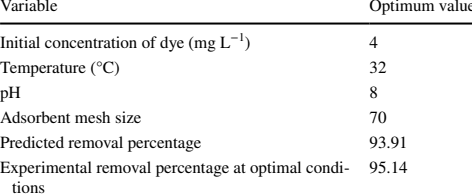

Variable  Optimum value
0              Initial concentration of dye (mg L−1)           4.00
1                                   Temperature (°C)          32.00
2                                                 pH           8.00
3                                Adsorbent mesh size          70.00
4                       Predicted removal percentage          93.91
5  Experimental removal percentage at optimal con...          95.14

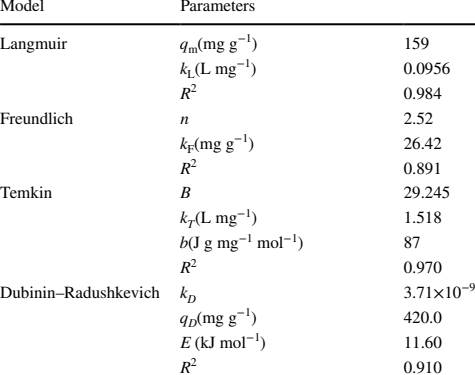

Model         Parameters Unnamed: 2
0               Langmuir         qm(mg g−1)        159
1               Langmuir         kL(L mg−1)     0.0956
2               Langmuir                 R2      0.984
3             Freundlich                  n       2.52
4             Freundlich         kF(mg g−1)      26.42
5             Freundlich                 R2      0.891
6                 Temkin                  B     29.245
7                 Temkin         kT(L mg−1)      1.518
8                 Temkin  b(J g mg−1 mol−1)         87
9                 Temkin                 R2      0.970
10  Dubinin–Radushkevich                 kD  3.71×10−9
11  Dubinin–Radushkevich         qD(mg g−1)      420.0
12  Dubinin–Radushkevich       E (kJ mol−1)      11.60
13  Dubinin–Radushkevich                 R2      0.910

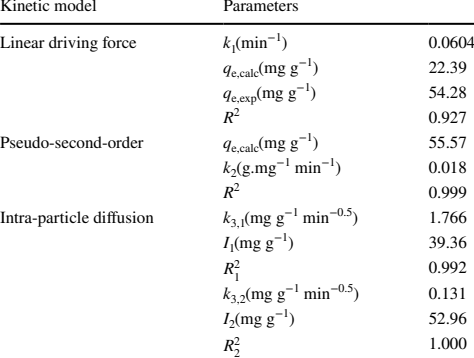

Kinetic model            Parameters  Parameters.1
0      Linear driving force             k1(min−1)        0.0604
1      Linear driving force       qe,calc(mg g−1)       22.3900
2      Linear driving force        qe,exp(mg g−1)       54.2800
3      Linear driving force                    R2        0.9270
4       Pseudo-second-order       qe,calc(mg g−1)       55.5700
5       Pseudo-second-order      k2(g.mg−1 min−1)        0.0180
6       Pseudo-second-order                    R2        0.9990
7   Intra-particle difusion  k3,1(mg g−1 min−0.5)        1.7660
8   Intra-particle difusion            I1(mg g−1)       39.3600
9   Intra-particle difusion                  R2 1        0.9920
10  Intra-particle difusion  k3,2(mg g−1 min−0.5)        0.1310
11  Intra-particle difusion            I2(mg g−1)       52.9600
12  Intra-particle difusion                  R2 2        1.0000

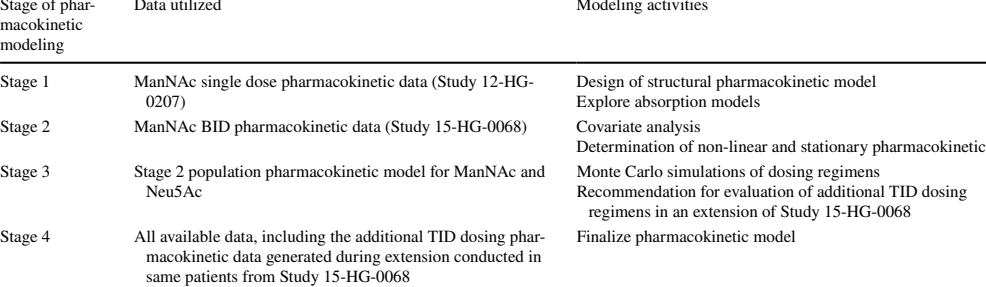

Stage of phar￾macokinetic modeling  \
0                            Stage 1   
1                            Stage 2   
2                            Stage 3   
3                            Stage 4   

                                       Data utilized  \
0  ManNAc single dose pharmacokinetic data (Study...   
1  ManNAc BID pharmacokinetic data (Study 15-HG-0...   
2  Stage 2 population pharmacokinetic model for M...   
3  All available data, including the additional T...   

                                 Modeling activities  
0  Design of structural pharmacokinetic model Exp...  
1  Covariate analysis Determination of non-linear...  
2  Monte Carlo simulations of dosing regimens Rec...  
3                     Finalize pharmacokinetic model

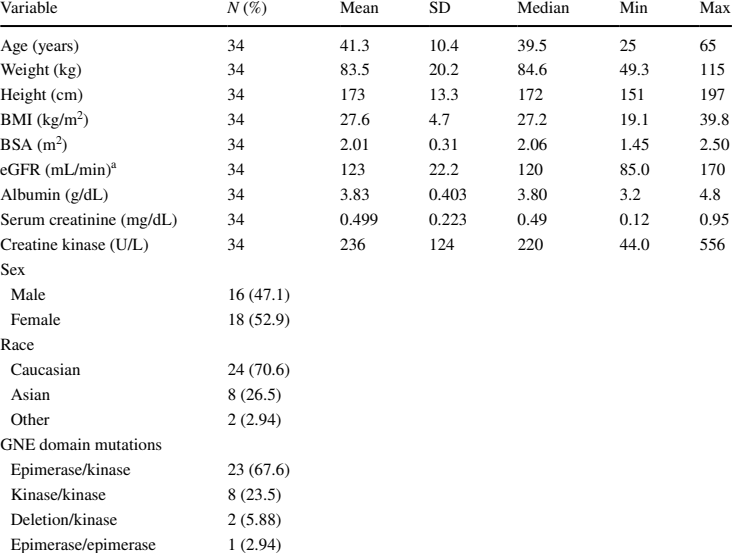

Variable      N (%)   Mean     SD Median    Min    Max  \
0                Age (years)         34   41.3   10.4   39.5   25.0   65.0   
1                Weight (kg)         34   83.5   20.2   84.6   49.3  115.0   
2                Height (cm)         34  173.0   13.3  172.0  151.0  197.0   
3               BMI (kg/m2 )         34   27.6    4.7   27.2   19.1   39.8   
4                  BSA (m2 )         34   2.01   0.31   2.06   1.45    2.5   
5             eGFR (mL/min)a         34  123.0   22.2  120.0   85.0  170.0   
6             Albumin (g/dL)         34   3.83  0.403    3.8    3.2    4.8   
7   Serum creatinine (mg/dL)         34  0.499  0.223   0.49   0.12   0.95   
8      Creatine kinase (U/L)         34  236.0  124.0  220.0   44.0  556.0   
9                        Sex                                                 
10                      Male  16 (47.1)                                      
11                    Female  18 (52.9)                                      
12                      Race                                                 
13                 Caucasian  24 (70.6)                                      
14                     Asian   8 (26.5)                                      
15                     Other   2 (2.94)                                      
16      GNE domain mutations                                                 
17          Epimerase/kinase  23 (67.6)                                      
18             Kinase/kinase   8 (23.5)                                      
19           Deletion/kinase   2 (5.88)                                      
20       Epimerase/epimerase   1 (2.94)                                      

    is_projecting_row  
0               False  
1               False  
2               False  
3               False  
4               False  
5               False  
6               False  
7               False  
8               False  
9                True  
10              False  
11              False  
12               True  
13              False  
14              False  
15              False  
16               True  
17              False  
18              False  
19              False  
20              False

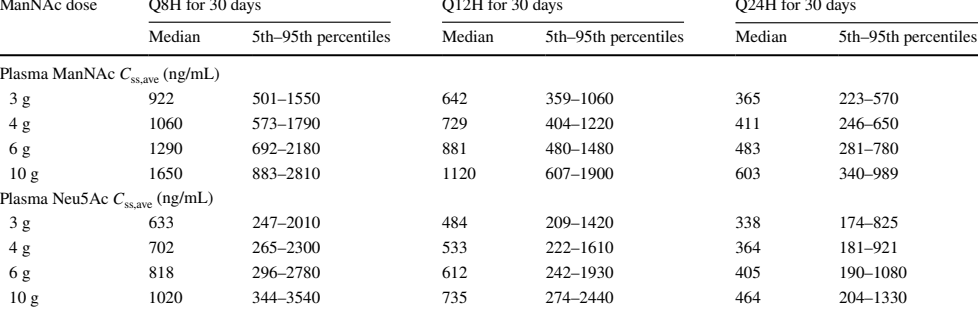

ManNAc dose Q8H for 30 days \nMedian  \
0  Plasma ManNAc          Css,ave (ng/mL)   
1            3 g                      922   
2            4 g                     1060   
3            6 g                     1290   
4           10 g                     1650   
5  Plasma Neu5Ac          Css,ave (ng/mL)   
6            3 g                      633   
7            4 g                      702   
8            6 g                      818   
9           10 g                     1020   

  Q8H for 30 days \n5th–95th percentiles Q12H for 30 days \nMedian  \
0                                                                    
1                               501–1550                     642.0   
2                               573–1790                     729.0   
3                               692–2180                     881.0   
4                               883–2810                    1120.0   
5                                                                    
6                               247–2010                     484.0   
7                               265–2300                     533.0   
8                               296–2780                     612.0   
9                               344–3540                     735.0   

  Q12H for 30 days \n5th–95th percentiles Q24H for 30 days \nMedian  \
0                                                                     
1                                359–1060                     365.0   
2                                404–1220                     411.0   
3                                480–1480                     483.0   
4                                607–1900                     603.0   
5                                                                     
6                                209–1420                     338.0   
7                                222–1610                     364.0   
8                                242–1930                     405.0   
9                                274–2440                     464.0   

  Q24H for 30 days \n5th–95th percentiles  is_projecting_row  
0                                                       True  
1                                 223–570              False  
2                                 246–650              False  
3                                 281–780              False  
4                                 340–989              False  
5                                                       True  
6                                 174–825              False  
7                                 181–921              False  
8                                190–1080              False  
9                                204–1330              False

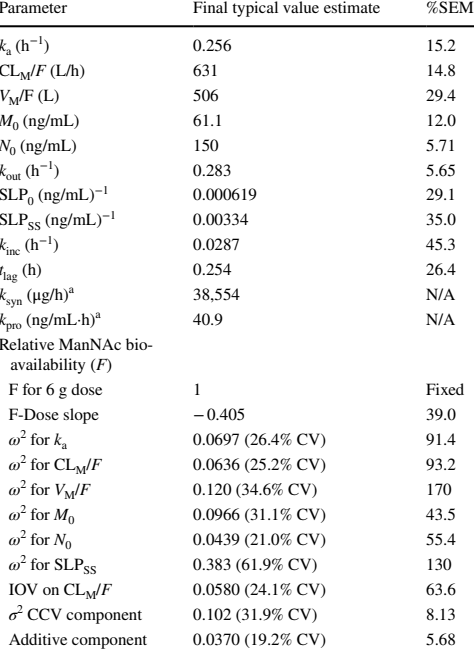

Parameter Final typical value estimate   %SEM  \
0                               ka (h−1)                        0.256   15.2   
1                            CLM/F (L/h)                          631   14.8   
2                               VM/F (L)                          506   29.4   
3                             M0 (ng/mL)                         61.1   12.0   
4                             N0 (ng/mL)                          150   5.71   
5                             kout (h−1)                        0.283   5.65   
6                         SLP0 (ng/mL)−1                     0.000619   29.1   
7                        SLPSS (ng/mL)−1                      0.00334   35.0   
8                             kinc (h−1)                       0.0287   45.3   
9                               tlag (h)                        0.254   26.4   
10                          ksyn (μg/h)a                       38,554          
11                       kpro (ng/mL·h)a                         40.9          
12  Relative ManNAc bio￾availability (F)                                       
13                        F for 6 g dose                            1  Fixed   
14                          F-Dose slope                       −0.405   39.0   
15                             ω2 for ka            0.0697 (26.4% CV)   91.4   
16                          ω2 for CLM/F            0.0636 (25.2% CV)   93.2   
17                           ω2 for VM/F             0.120 (34.6% CV)    170   
18                             ω2 for M0            0.0966 (31.1% CV)   43.5   
19                             ω2 for N0            0.0439 (21.0% CV)   55.4   
20                          ω2 for SLPSS             0.383 (61.9% CV)    130   
21                          IOV on CLM/F            0.0580 (24.1% CV)   63.6   
22                      σ2 CCV component             0.102 (31.9% CV)   8.13   
23                    Additive component            0.0370 (19.2% CV)   5.68   

    is_projecting_row  
0               False  
1               False  
2               False  
3               False  
4               False  
5               False  
6               False  
7               False  
8               False  
9               False  
10              False  
11              False  
12               True  
13              False  
14              False  
15              False  
16              False  
17              False  
18              False  
19              False  
20              False  
21              False  
22              False  
23              False

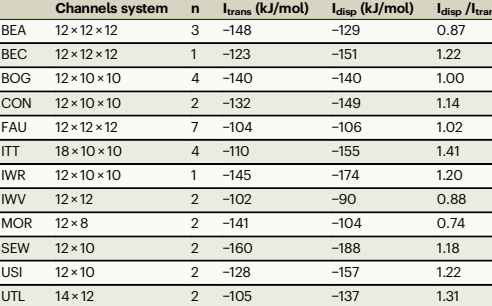

Unnamed: 0 Channels system  n Itrans (kJ/mol) Idisp (kJ/mol)  Idisp /Itrans
0         BEA    12 × 12 × 12  3            −148           −129           0.87
1         BEC    12 × 12 × 12  1            −123           −151           1.22
2         BOG    12 × 10 × 10  4            −140           −140           1.00
3         CON    12 × 10 × 10  2            −132           −149           1.14
4         FAU    12 × 12 × 12  7            −104           −106           1.02
5         ITT    18 × 10 × 10  4            −110           −155           1.41
6         IWR    12 × 10 × 10  1            −145           −174           1.20
7         IWV         12 × 12  2            −102            −90           0.88
8         MOR          12 × 8  2            −141           −104           0.74
9         SEW         12 × 10  2            −160           −188           1.18
10        USI         12 × 10  2            −128           −157           1.22
11        UTL         14 × 12  2            −105           −137           1.31

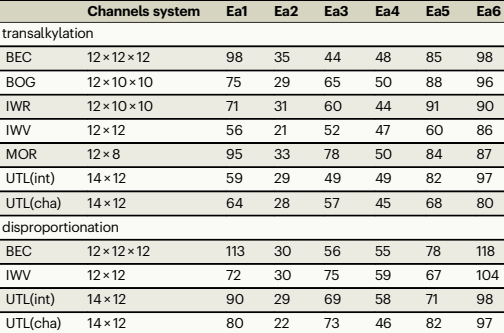

Unnamed: 0 Channels system    Ea1   Ea2   Ea3   Ea4   Ea5    Ea6  \
0      transalkylation                                                         
1                  BEC    12 × 12 × 12   98.0  35.0  44.0  48.0  85.0   98.0   
2                  BOG    12 × 10 × 10   75.0  29.0  65.0  50.0  88.0   96.0   
3                  IWR    12 × 10 × 10   71.0  31.0  60.0  44.0  91.0   90.0   
4                  IWV         12 × 12   56.0  21.0  52.0  47.0  60.0   86.0   
5                  MOR          12 × 8   95.0  33.0  78.0  50.0  84.0   87.0   
6             UTL(int)         14 × 12   59.0  29.0  49.0  49.0  82.0   97.0   
7             UTL(cha)         14 × 12   64.0  28.0  57.0  45.0  68.0   80.0   
8   disproportionation                                                         
9                  BEC    12 × 12 × 12  113.0  30.0  56.0  55.0  78.0  118.0   
10                 IWV         12 × 12   72.0  30.0  75.0  59.0  67.0  104.0   
11            UTL(int)         14 × 12   90.0  29.0  69.0  58.0  71.0   98.0   
12            UTL(cha)         14 × 12   80.0  22.0  73.0  46.0  82.0   97.0   

    is_projecting_row  
0                True  
1               False  
2               False  
3               False  
4               False  
5               False  
6               False  
7               False  
8                True  
9               False  
10              False  
11              False  
12              False

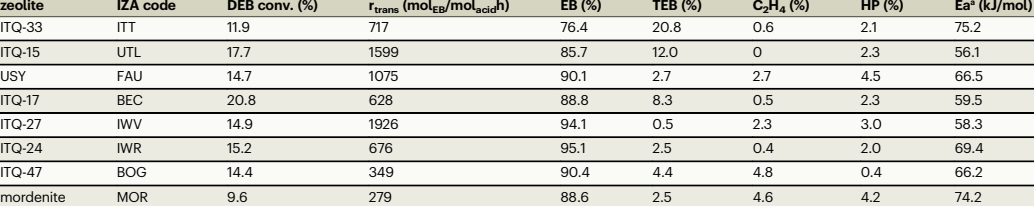

zeolite IZA code  DEB conv. (%)  rtrans (molEB/molacidh)  EB (%)  \
0     ITQ-33      ITT           11.9                      717    76.4   
1     ITQ-15      UTL           17.7                     1599    85.7   
2        USY      FAU           14.7                     1075    90.1   
3     ITQ-17      BEC           20.8                      628    88.8   
4     ITQ-27      IWV           14.9                     1926    94.1   
5     ITQ-24      IWR           15.2                      676    95.1   
6     ITQ-47      BOG           14.4                      349    90.4   
7  mordenite      MOR            9.6                      279    88.6   

   TEB (%)  C2H4 (%)  HP (%)  Eaa (kJ/mol)  
0     20.8       0.6     2.1          75.2  
1     12.0       0.0     2.3          56.1  
2      2.7       2.7     4.5          66.5  
3      8.3       0.5     2.3          59.5  
4      0.5       2.3     3.0          58.3  
5      2.5       0.4     2.0          69.4  
6      4.4       4.8     0.4          66.2  
7      2.5       4.6     4.2          74.2

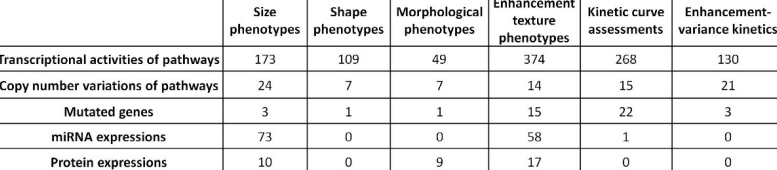

Empty DataFrame
Columns: [Unnamed: 0, Unnamed: 1, Unnamed: 2, Unnamed: 3, Unnamed: 4, Unnamed: 5, Unnamed: 6]
Index: []

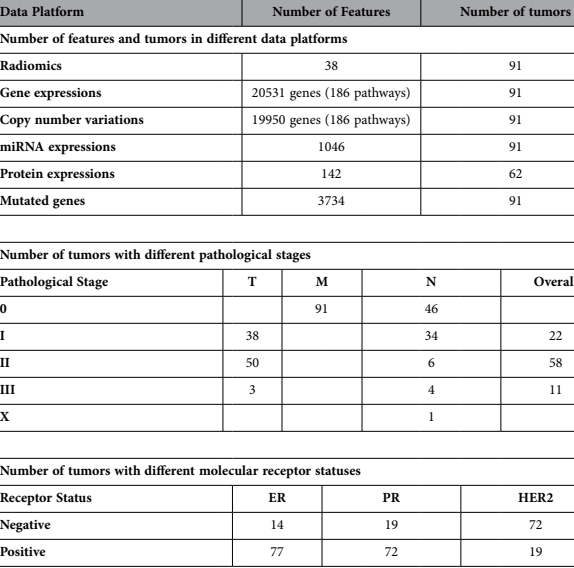

Data Platform Number of Features Number of Features.1  \
0     Number of features and tumors  in different data            platforms   
1                         Radiomics                                      38   
2                  Gene expressions              20531           genes (186   
3            Copy number variations              19950           genes (186   
4                 miRNA expressions                                    1046   
5               Protein expressions                                     142   
6                     Mutated genes                                    3734   
7   Number of tumors with different       pathological               stages   
8                Pathological Stage                  T                    M   
9                                 0                                      91   
10                                I                 38                        
11                               II                 50                        
12                              III                  3                        
13                                X                                           
14  Number of tumors with different          molecular    receptor statuses   
15                  Receptor Status                 ER                        
16                         Negative                 14                        
17                         Positive                 77                        

   Number of Features.2 Number of tumors  is_projecting_row  
0                                                      True  
1                                     91              False  
2             pathways)               91              False  
3             pathways)               91              False  
4                                     91              False  
5                                     62              False  
6                                     91              False  
7                                                     False  
8                     N          Overall              False  
9                    46                               False  
10                   34               22              False  
11                    6               58              False  
12                    4               11              False  
13                    1                               False  
14                                                     True  
15                   PR             HER2              False  
16                   19               72              False  
17                   72               19              False

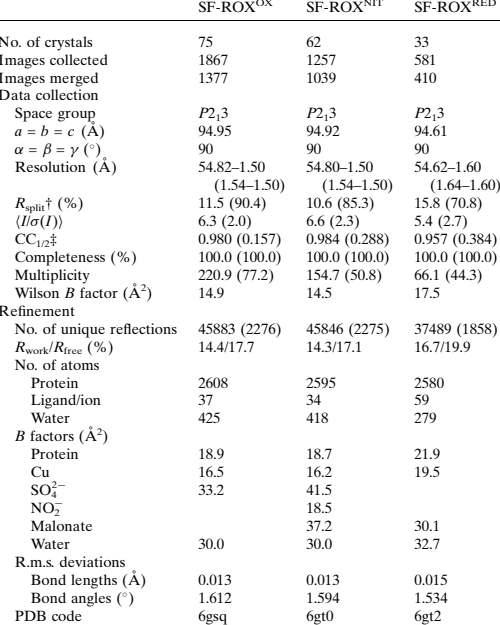

Unnamed: 0       SF-ROXOX      SF-ROXNIT      SF-ROXRED  \
0             No. of crystals             75             62             33   
1            Images collected           1867           1257            581   
2               Images merged           1377           1039            410   
3             Data collection                                                
4                 Space group           P213           P213           P213   
5             a = b = c (A˚ )          94.95          94.92          94.61   
6               =  =  ( )             90             90             90   
7            Resolution (A˚ )     54.82–1.50     54.80–1.50     54.62–1.60   
8                                (1.54–1.50)    (1.54–1.50)    (1.64–1.60)   
9                 Rsplit† (%)    11.5 (90.4)    10.6 (85.3)    15.8 (70.8)   
10                   hI/(I)i      6.3 (2.0)      6.6 (2.3)      5.4 (2.7)   
11                     CC1/2‡  0.980 (0.157)  0.984 (0.288)  0.957 (0.384)   
12           Completeness (%)  100.0 (100.0)  100.0 (100.0)  100.0 (100.0)   
13               Multiplicity   220.9 (77.2)   154.7 (50.8)    66.1 (44.3)   
14    Wilson B factor (A˚ 2 )           14.9           14.5           17.5   
15                 Refinement                                                
16  No. of unique reflections   45883 (2276)   45846 (2275)   37489 (1858)   
17            Rwork/Rfree (%)      14.4/17.7      14.3/17.1      16.7/19.9   
18               No. of atoms                                                
19                    Protein           2608           2595           2580   
20                 Ligand/ion             37             34             59   
21                      Water            425            418            279   
22          B factors (A˚ 2 )                                                
23                    Protein           18.9           18.7           21.9   
24                         Cu           16.5           16.2           19.5   
25                      SO4 2           33.2           41.5                  
26                   NO2 18.5                                                
27                   Malonate                          37.2           30.1   
28                      Water           30.0           30.0           32.7   
29          R.m.s. deviations                                                
30         Bond lengths (A˚ )          0.013          0.013          0.015   
31            Bond angles ()          1.612          1.594          1.534   
32                   PDB code           6gsq           6gt0           6gt2   

    is_projecting_row  
0               False  
1               False  
2               False  
3               False  
4               False  
5               False  
6               False  
7               False  
8               False  
9               False  
10              False  
11              False  
12              False  
13              False  
14              False  
15               True  
16              False  
17              False  
18               True  
19              False  
20              False  
21              False  
22               True  
23              False  
24              False  
25              False  
26              False  
27              False  
28              False  
29               True  
30              False  
31              False  
32              False

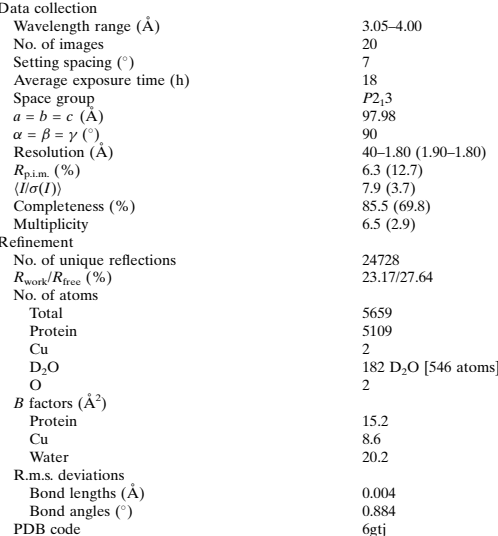

Unnamed: 0           Unnamed: 1  is_projecting_row
0             Data collection                                   False
1      Wavelength range (A˚ )            3.05–4.00              False
2               No. of images                   20              False
3         Setting spacing ()                    7              False
4   Average exposure time (h)                   18              False
5                 Space group                 P213              False
6             a = b = c (A˚ )                97.98              False
7               =  =  ( )                   90              False
8            Resolution (A˚ )  40–1.80 (1.90–1.80)              False
9                 Rp.i.m. (%)           6.3 (12.7)              False
10                   hI/(I)i            7.9 (3.7)              False
11           Completeness (%)          85.5 (69.8)              False
12               Multiplicity            6.5 (2.9)              False
13                 Refinement                                    True
14  No. of unique reflections                24728              False
15            Rwork/Rfree (%)          23.17/27.64              False
16               No. of atoms                                    True
17                      Total                 5659              False
18                    Protein                 5109              False
19                         Cu                    2              False
20                        D2O  182 D2O [546 atoms]              False
21                          O                    2              False
22          B factors (A˚ 2 )                                    True
23                    Protein                 15.2              False
24                         Cu                  8.6              False
25                      Water                 20.2              False
26          R.m.s. deviations                                    True
27         Bond lengths (A˚ )                0.004              False
28            Bond angles ()                0.884              False
29                   PDB code                 6gtj              False

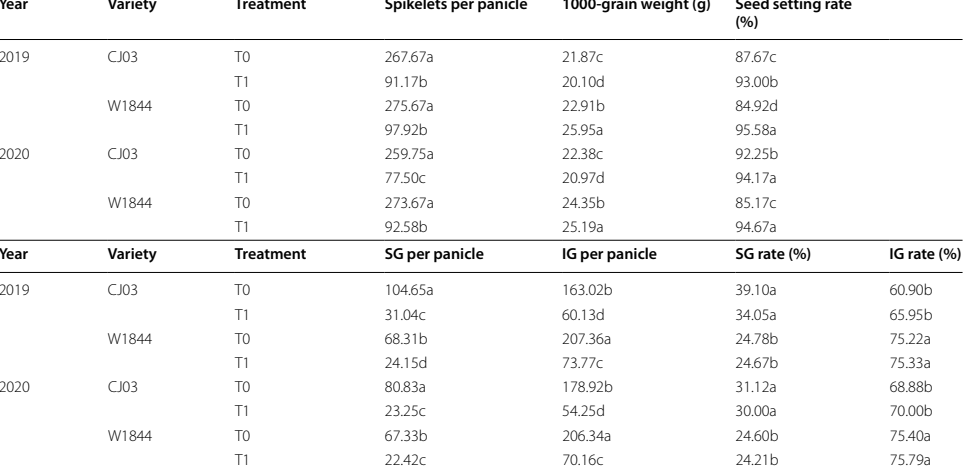

Year  Variety  Treatment Spikelets per panicle 1000-grain weight (g)  \
0   2019     CJ03         T0               267.67a                21.87c   
1   2019                  T1                91.17b                20.10d   
2   2019    W1844         T0               275.67a                22.91b   
3   2019                  T1                97.92b                25.95a   
4   2020     CJ03         T0               259.75a                22.38c   
5   2020                  T1                77.50c                20.97d   
6   2020    W1844         T0               273.67a                24.35b   
7   2020                  T1                92.58b                25.19a   
8   Year  Variety  Treatment        SG per panicle        IG per panicle   
9   2019     CJ03         T0               104.65a               163.02b   
10  2019                  T1                31.04c                60.13d   
11  2019    W1844         T0                68.31b               207.36a   
12  2019                  T1                24.15d                73.77c   
13  2020     CJ03         T0                80.83a               178.92b   
14  2020                  T1                23.25c                54.25d   
15  2020    W1844         T0                67.33b               206.34a   
16  2020                  T1                22.42c                70.16c   

   Seed setting rate (%) Seed setting rate (%).1  
0                 87.67c                          
1                 93.00b                          
2                 84.92d                          
3                 95.58a                          
4                 92.25b                          
5                 94.17a                          
6                 85.17c                          
7                 94.67a                          
8            SG rate (%)             IG rate (%)  
9                 39.10a                  60.90b  
10                34.05a                  65.95b  
11                24.78b                  75.22a  
12                24.67b                  75.33a  
13                31.12a                  68.88b  
14                30.00a                  70.00b  
15                24.60b                  75.40a  
16                24.21b                  75.79a

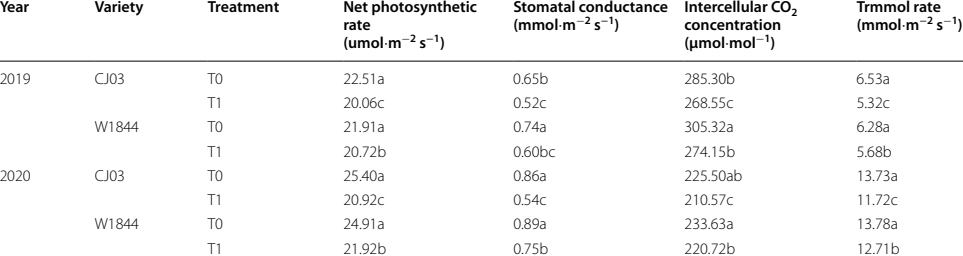

Year Variety Treatment Net photosynthetic rate (umol·m−2 s−1 )  \
0  2019    CJ03        T0                                  22.51a   
1  2019                T1                                  20.06c   
2  2019   W1844        T0                                  21.91a   
3  2019                T1                                  20.72b   
4  2020    CJ03        T0                                  25.40a   
5  2020                T1                                  20.92c   
6  2020   W1844        T0                                  24.91a   
7  2020                T1                                  21.92b   

  Stomatal conductance (mmol·m−2 s−1 )  \
0                                0.65b   
1                                0.52c   
2                                0.74a   
3                               0.60bc   
4                                0.86a   
5                                0.54c   
6                                0.89a   
7                                0.75b   

  Intercellular CO2 concentration (μmol·mol−1 ) Trmmol rate (mmol·m−2 s−1 )  
0                                       285.30b                       6.53a  
1                                       268.55c                       5.32c  
2                                       305.32a                       6.28a  
3                                       274.15b                       5.68b  
4                                      225.50ab                      13.73a  
5                                       210.57c                      11.72c  
6                                       233.63a                      13.78a  
7                                       220.72b                      12.71b

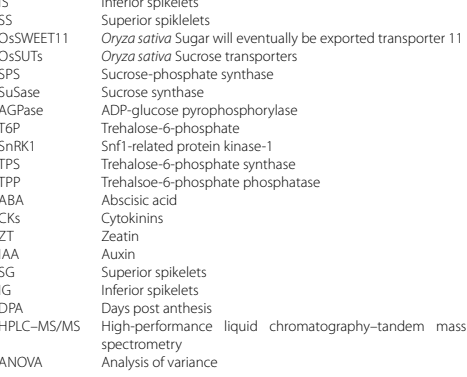

IS                    Inferior spikelets  \
0           SS                   Superior spiklelets   
1    OsSWEET11               Oryza sativa Sugar will   
2       OsSUTs                  Oryza sativa Sucrose   
3          SPS                     Sucrose-phosphate   
4       SuSase                      Sucrose synthase   
5       AGPase                           ADP-glucose   
6          T6P                 Trehalose-6-phosphate   
7        SnRK1                  Snf1-related protein   
8          TPS                 Trehalose-6-phosphate   
9          TPP                 Trehalsoe-6-phosphate   
10         ABA                         Abscisic acid   
11         CKs                            Cytokinins   
12          ZT                                Zeatin   
13         IAA                                 Auxin   
14          SG                    Superior spikelets   
15          IG                    Inferior spikelets   
16         DPA                    Days post anthesis   
17  HPLC–MS/MS  High-performance liquid spectrometry   
18       ANOVA                  Analysis of variance   

                            Unnamed: 2 Unnamed: 3  
0                                                  
1   eventually be exported transporter         11  
2                         transporters             
3                             synthase             
4                                                  
5                    pyrophosphorylase             
6                                                  
7                             kinase-1             
8                             synthase             
9                          phosphatase             
10                                                 
11                                                 
12                                                 
13                                                 
14                                                 
15                                                 
16                                                 
17               chromatography–tandem       mass  
18

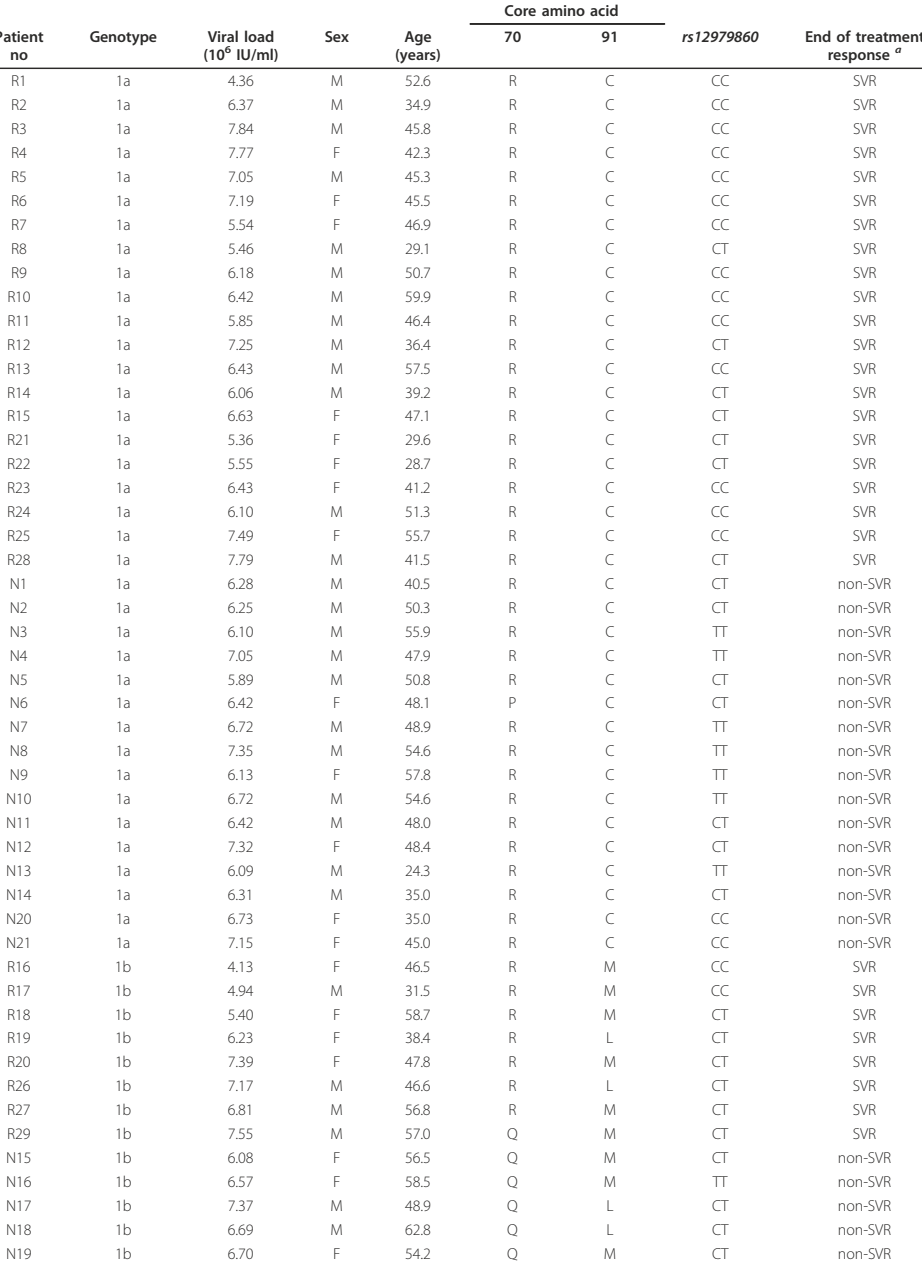

Patient no Genotype  Viral load (106 IU/ml) Sex  Age (years)  \
0          R1       1a                    4.36   M         52.6   
1          R2       1a                    6.37   M         34.9   
2          R3       1a                    7.84   M         45.8   
3          R4       1a                    7.77   F         42.3   
4          R5       1a                    7.05   M         45.3   
5          R6       1a                    7.19   F         45.5   
6          R7       1a                    5.54   F         46.9   
7          R8       1a                    5.46   M         29.1   
8          R9       1a                    6.18   M         50.7   
9         R10       1a                    6.42   M         59.9   
10        R11       1a                    5.85   M         46.4   
11        R12       1a                    7.25   M         36.4   
12        R13       1a                    6.43   M         57.5   
13        R14       1a                    6.06   M         39.2   
14        R15       1a                    6.63   F         47.1   
15        R21       1a                    5.36   F         29.6   
16        R22       1a                    5.55   F         28.7   
17        R23       1a                    6.43   F         41.2   
18        R24       1a                    6.10   M         51.3   
19        R25       1a                    7.49   F         55.7   
20        R28       1a                    7.79   M         41.5   
21         N1       1a                    6.28   M         40.5   
22         N2       1a                    6.25   M         50.3   
23         N3       1a                    6.10   M         55.9   
24         N4       1a                    7.05   M         47.9   
25         N5       1a                    5.89   M         50.8   
26         N6       1a                    6.42   F         48.1   
27         N7       1a                    6.72   M         48.9   
28         N8       1a                    7.35   M         54.6   
29         N9       1a                    6.13   F         57.8   
30        N10       1a                    6.72   M         54.6   
31        N11       1a                    6.42   M         48.0   
32        N12       1a                    7.32   F         48.4   
33        N13       1a                    6.09   M         24.3   
34        N14       1a                    6.31   M         35.0   
35        N20       1a                    6.73   F         35.0   
36        N21       1a                    7.15   F         45.0   
37        R16       1b                    4.13   F         46.5   
38        R17       1b                    4.94   M         31.5   
39        R18       1b                    5.40   F         58.7   
40        R19       1b                    6.23   F         38.4   
41        R20       1b                    7.39   F         47.8   
42        R26       1b                    7.17   M         46.6   
43        R27       1b                    6.81   M         56.8   
44        R29       1b                    7.55   M         57.0   
45        N15       1b                    6.08   F         56.5   
46        N16       1b                    6.57   F         58.5   
47        N17       1b                    7.37   M         48.9   
48        N18       1b                    6.69   M         62.8   
49        N19       1b                    6.70   F         54.2   

   Core amino acid \n70 Core amino acid \n91 rs12979860  \
0                     R                    C         CC   
1                     R                    C         CC   
2                     R                    C         CC   
3                     R                    C         CC   
4                     R                    C         CC   
5                     R                    C         CC   
6                     R                    C         CC   
7                     R                    C         CT   
8                     R                    C         C

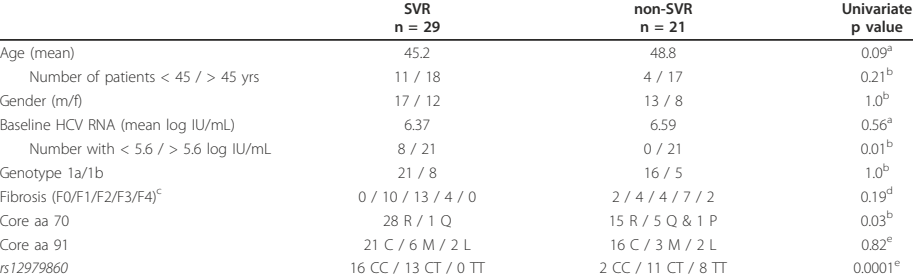

Unnamed: 0            SVR n = 29  \
0                           Age (mean)                  45.2   
1   Number of patients < 45 / > 45 yrs               11 / 18   
2                         Gender (m/f)               17 / 12   
3    Baseline HCV RNA (mean log IU/mL)                  6.37   
4  Number with < 5.6 / > 5.6 log IU/mL                8 / 21   
5                       Genotype 1a/1b                21 / 8   
6           Fibrosis (F0/F1/F2/F3/F4)c   0 / 10 / 13 / 4 / 0   
7                           Core aa 70            28 R / 1 Q   
8                           Core aa 91      21 C / 6 M / 2 L   
9                           rs12979860  16 CC / 13 CT / 0 TT   

        non-SVR n = 21 Univariate p value  
0                 48.8              0.09a  
1               4 / 17              0.21b  
2               13 / 8               1.0b  
3                 6.59              0.56a  
4               0 / 21              0.01b  
5               16 / 5               1.0b  
6    2 / 4 / 4 / 7 / 2              0.19d  
7     15 R / 5 Q & 1 P              0.03b  
8     16 C / 3 M / 2 L              0.82e  
9  2 CC / 11 CT / 8 TT            0.0001e

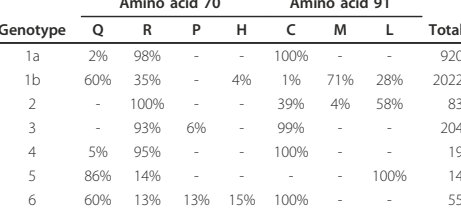

Genotype Amino acid 70 \nQ Amino acid 70 \nR Amino acid 70 \nP  \
0       1a                2%               98%                 -   
1       1b               60%               35%                 -   
2        2                 -              100%                 -   
3        3                 -               93%                6%   
4        4                5%               95%                 -   
5        5               86%               14%                 -   
6        6               60%               13%               13%   

  Amino acid 70 \nH Amino acid 91 \nC Amino acid 91 \nM Amino acid 91 \nL  \
0                 -              100%                 -                 -   
1                4%                1%               71%               28%   
2                 -               39%                4%               58%   
3                 -               99%                 -                 -   
4                 -              100%                 -                 -   
5                 -                 -                 -              100%   
6               15%              100%                 -                 -   

   Total  
0    920  
1   2022  
2     83  
3    204  
4     19  
5     14  
6     55

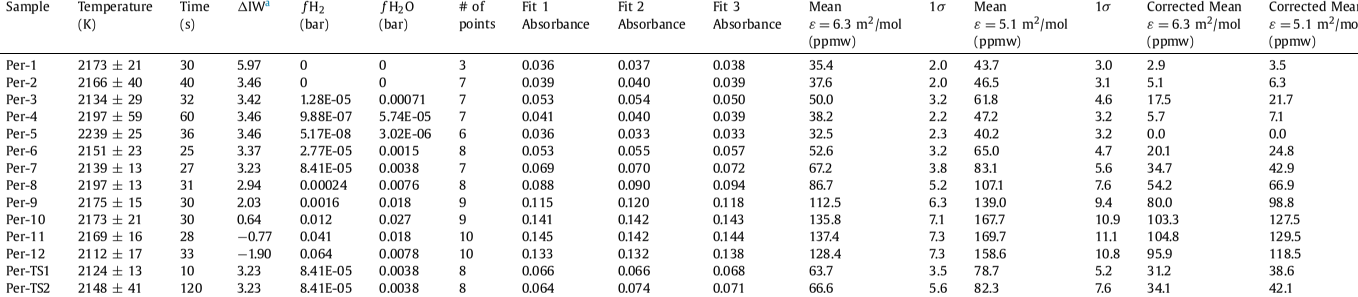

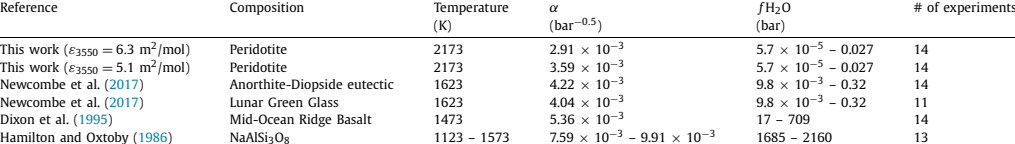

This work (ε3550 = 6.3 m2/mol)                   Peridotite     (K) 2173  \
0  This work (ε3550 = 5.1 m2/mol)                   Peridotite         2173   
1          Newcombe et al. (2017)  Anorthite-Diopside eutectic         1623   
2          Newcombe et al. (2017)            Lunar Green Glass         1623   
3             Dixon et al. (1995)       Mid-Ocean Ridge Basalt         1473   
4      Hamilton and Oxtoby (1986)                    NaAlSi3O8  1123 – 1573   

  Unnamed: 3      (bar−0.5) 2.91 × 10−3 (bar) 5.7 × 10−5 – 0.027  14  
0                           3.59 × 10−3       5.7 × 10−5 – 0.027  14  
1                           4.22 × 10−3        9.8 × 10−3 – 0.32  14  
2                           4.04 × 10−3        9.8 × 10−3 – 0.32  11  
3                           5.36 × 10−3                 17 – 709  14  
4             7.59 × 10−3 – 9.91 × 10−3              1685 – 2160  13

In [ ]:
from IPython.display import Image, display
import pandas as pd
for subdir in sorted(os.listdir("results")):
    for filename in sorted(os.listdir(f"results/{subdir}")):
        if filename.endswith(".png"):
            display(Image(f"results/{subdir}/{filename}"))
            csv = filename[:-4] + ".csv"
            if os.path.exists(f"results/{subdir}/{csv}"):
                df = pd.read_csv(f"results/{subdir}/{csv}")
                df.fillna("",inplace=True)
                with pd.option_context('display.max_rows', None, 'display.max_columns', None):
                    display(df)

Strengths:
- alignment accuracy
- small and medium size tables
- throughput

Recent additions:
- rotated/vertical tables (v0.0.4)
- multi-indexes (v0.2)

Weaknesses:
- underlying OCR issues
- uneven columns, as in 4.pdf